In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold 
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.metrics import mean_squared_error, r2_score
import xgboost
# Import module

from sklearn.metrics import explained_variance_score


  <font size="+2">**Importing Data Set**</font>

The objective being the prediction of prices for different real estate values, we will be tailoring our data around that.

In [2]:
data = pd.read_excel('../input/AgencyDataset/AgencyDataset.xlsx')
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02,313000.0,3,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02,2384000.0,5,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02,342000.0,3,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02,420000.0,3,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02,550000.0,4,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


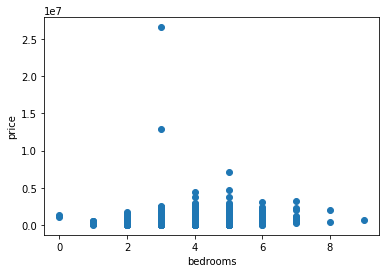

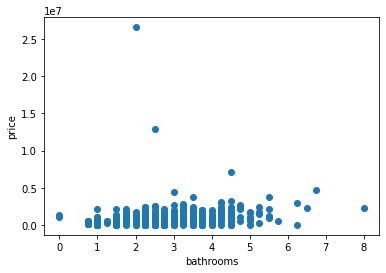

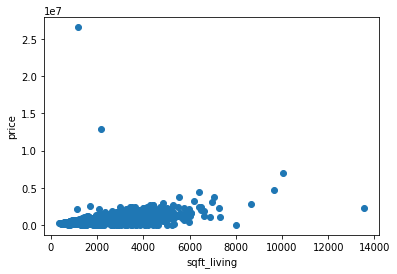

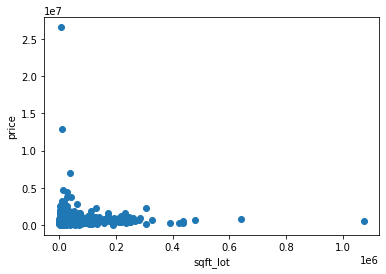

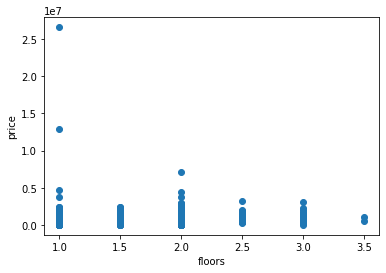

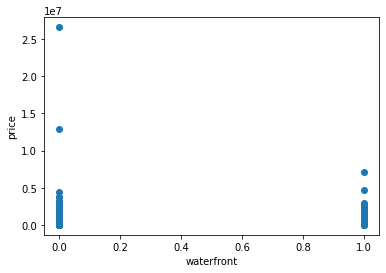

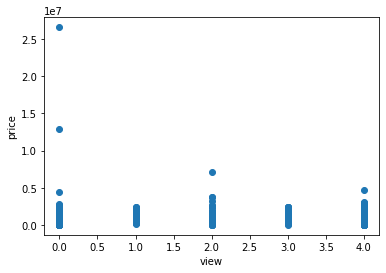

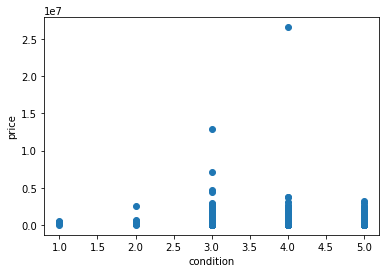

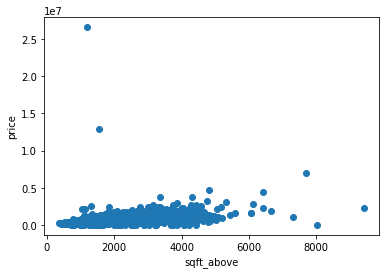

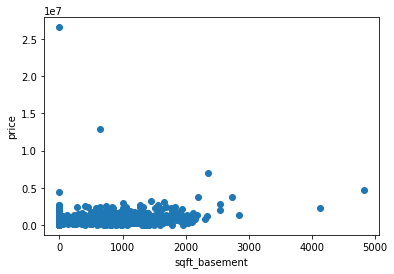

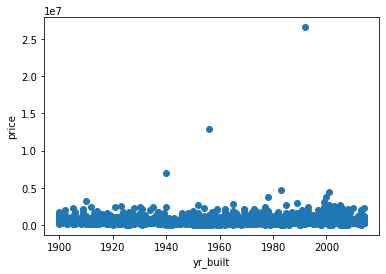

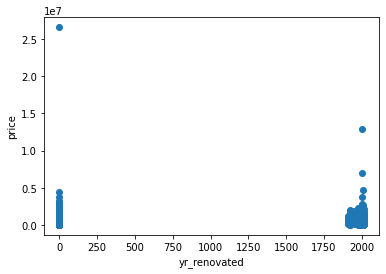

In [3]:
# Visualization -73
labels = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
y = 'price'
for i in range(len(labels)):
    plt.figure()
    plt.scatter(data[labels[i]], data[y])
    plt.xlabel(labels[i])
    plt.ylabel(y)

In [4]:
data["price"].describe()

count    4.600000e+03
mean     5.519630e+05
std      5.638347e+05
min      0.000000e+00
25%      3.228750e+05
50%      4.609435e+05
75%      6.549625e+05
max      2.659000e+07
Name: price, dtype: float64

In [5]:
# Check for duplicated rows
print("Number of duplicate rows: ", sum(data.duplicated()))

Number of duplicate rows:  0


  <font size="+2">**Data Cleaning**</font>

First we're gonna deal with outliers, Some price values are null & others are too high & unrealistic and cause false correlations with price, Gonna get rid of those first

In [6]:
count = (data['price'] == 0).sum()
print('Count of zeros in Column price : ', count)

Count of zeros in Column price :  49


In [7]:
price_null=data.index[data['price'] == 0].tolist()
price_null

[4354,
 4356,
 4357,
 4358,
 4361,
 4362,
 4374,
 4376,
 4382,
 4383,
 4385,
 4386,
 4389,
 4394,
 4405,
 4408,
 4411,
 4412,
 4413,
 4420,
 4442,
 4448,
 4453,
 4454,
 4472,
 4478,
 4479,
 4480,
 4481,
 4487,
 4499,
 4507,
 4509,
 4520,
 4521,
 4522,
 4523,
 4528,
 4534,
 4542,
 4552,
 4554,
 4555,
 4558,
 4563,
 4567,
 4574,
 4575,
 4588]

In [8]:
data = data.drop(price_null, axis=0)

In [9]:
count = (data['price'] == 0).sum()
print('Count of zeros in Column price : ', count)

Count of zeros in Column price :  0


In [10]:
price_max=data.index[data['price']>25000000].tolist()

price_max

[4350]

In [11]:
data=data.drop(price_max, axis=0)

In [12]:
price_max2=data.index[data['price']>10000000].tolist()

price_max2

[4346]

In [13]:
data=data.drop(price_max2, axis=0)

In [14]:
price_max3=data.index[data['price']>7000000].tolist()

price_max3

[2286]

In [15]:
data=data.drop(price_max3, axis=0)

  <font size="+2">**Data Cleaning**</font>

First & foremost, check for na data.

In [16]:
data.isna().sum()
#Value might change after encoding object types

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

We will be dropping the date collumn from the Data as it's irrelevent to the price prediction!

In [17]:
data = data.drop(['date'], axis = 1)
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,313000.0,3,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2384000.0,5,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,342000.0,3,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,420000.0,3,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,550000.0,4,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [18]:
data["country"].nunique()

1

In [19]:
data[['state','zip_code']] = data.statezip.str.split(" ",expand=True,)
data['state'].nunique()
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,state,zip_code
0,313000.0,3,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA,WA,98133
1,2384000.0,5,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA,WA,98119
2,342000.0,3,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA,WA,98042
3,420000.0,3,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA,WA,98008
4,550000.0,4,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA,WA,98052


As we checked, country only possessed 1 value so we're gonna drop it.
Seperating statezip into 2 features also shows that WA is the only state we're working with here so we're gonna keep just the numerical value to avoid having to encode it.
We're also dropping the street collumn as it seems irrelevent.

In [20]:
data=data.drop(['country','state','statezip'],axis=1)


In [21]:
data=data.drop(['street'],axis=1)


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4548 entries, 0 to 4599
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4548 non-null   float64
 1   bedrooms       4548 non-null   int64  
 2   bathrooms      4548 non-null   float64
 3   sqft_living    4548 non-null   int64  
 4   sqft_lot       4548 non-null   int64  
 5   floors         4548 non-null   float64
 6   waterfront     4548 non-null   int64  
 7   view           4548 non-null   int64  
 8   condition      4548 non-null   int64  
 9   sqft_above     4548 non-null   int64  
 10  sqft_basement  4548 non-null   int64  
 11  yr_built       4548 non-null   int64  
 12  yr_renovated   4548 non-null   int64  
 13  city           4548 non-null   object 
 14  zip_code       4548 non-null   object 
dtypes: float64(3), int64(10), object(2)
memory usage: 568.5+ KB


As we can see, we need to encode the zip_code & city.
Note 1: We could convert zip_code to a 16bit integer value but that could lead to wrong assumptions by the model so adding a dict & encoding seems to be the best solution for now.

In [23]:
from sklearn.preprocessing import LabelEncoder
print('Categorical columns: ')
for col in data.columns:
    if data[col].dtype == 'object':
        values = data[col].value_counts()
        values = dict(values)
        
        print(str(col))
        label = LabelEncoder()
        label = label.fit(data[col])
        data[col] = label.transform(data[col].astype(str))
        
        new_values = data[col].value_counts()
        new_values = dict(new_values)
        
        value_dict = {}
        i=0
        for key in values:
            value_dict[key] = list(new_values)[i]
            i+= 1
        print(value_dict)

Categorical columns: 
city
{'Seattle': 35, 'Renton': 32, 'Bellevue': 3, 'Redmond': 31, 'Kirkland': 19, 'Issaquah': 16, 'Kent': 18, 'Auburn': 1, 'Sammamish': 33, 'Federal Way': 14, 'Shoreline': 36, 'Woodinville': 42, 'Maple Valley': 21, 'Mercer Island': 23, 'Burien': 6, 'Snoqualmie': 38, 'Kenmore': 17, 'Des Moines': 10, 'North Bend': 27, 'Duvall': 11, 'Covington': 9, 'Lake Forest Park': 20, 'Bothell': 5, 'Newcastle': 25, 'Tukwila': 40, 'Vashon': 41, 'SeaTac': 34, 'Enumclaw': 12, 'Carnation': 7, 'Normandy Park': 26, 'Fall City': 13, 'Medina': 22, 'Clyde Hill': 8, 'Black Diamond': 4, 'Ravensdale': 30, 'Pacific': 28, 'Algona': 0, 'Yarrow Point': 43, 'Skykomish': 37, 'Preston': 29, 'Milton': 24, 'Inglewood-Finn Hill': 15, 'Snoqualmie Pass': 39, 'Beaux Arts Village': 2}
zip_code
{'98103': 47, '98052': 31, '98117': 56, '98115': 54, '98006': 5, '98059': 37, '98034': 22, '98042': 26, '98053': 32, '98038': 23, '98058': 36, '98027': 15, '98074': 42, '98023': 13, '98133': 62, '98033': 21, '98125':

In [24]:
data = (data.loc[:, ~data.columns.isin(['lat', 'long'])]).round(0).astype(int)
data.head(5)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city,zip_code
0,313000,3,2,1340,7912,2,0,0,3,1340,0,1955,2005,36,62
1,2384000,5,2,3650,9050,2,0,4,5,3370,280,1921,0,35,58
2,342000,3,2,1930,11947,1,0,0,4,1930,0,1966,0,18,26
3,420000,3,2,2000,8030,1,0,0,4,1000,1000,1963,0,3,7
4,550000,4,2,1940,10500,1,0,0,4,1140,800,1976,1992,31,31


In [25]:
data.isnull().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
city             0
zip_code         0
dtype: int64

Okay so even after encoding, no non available or duplicates seem to appear so mostly cleaned data.

  <font size="+2">**Data Analysis**</font>

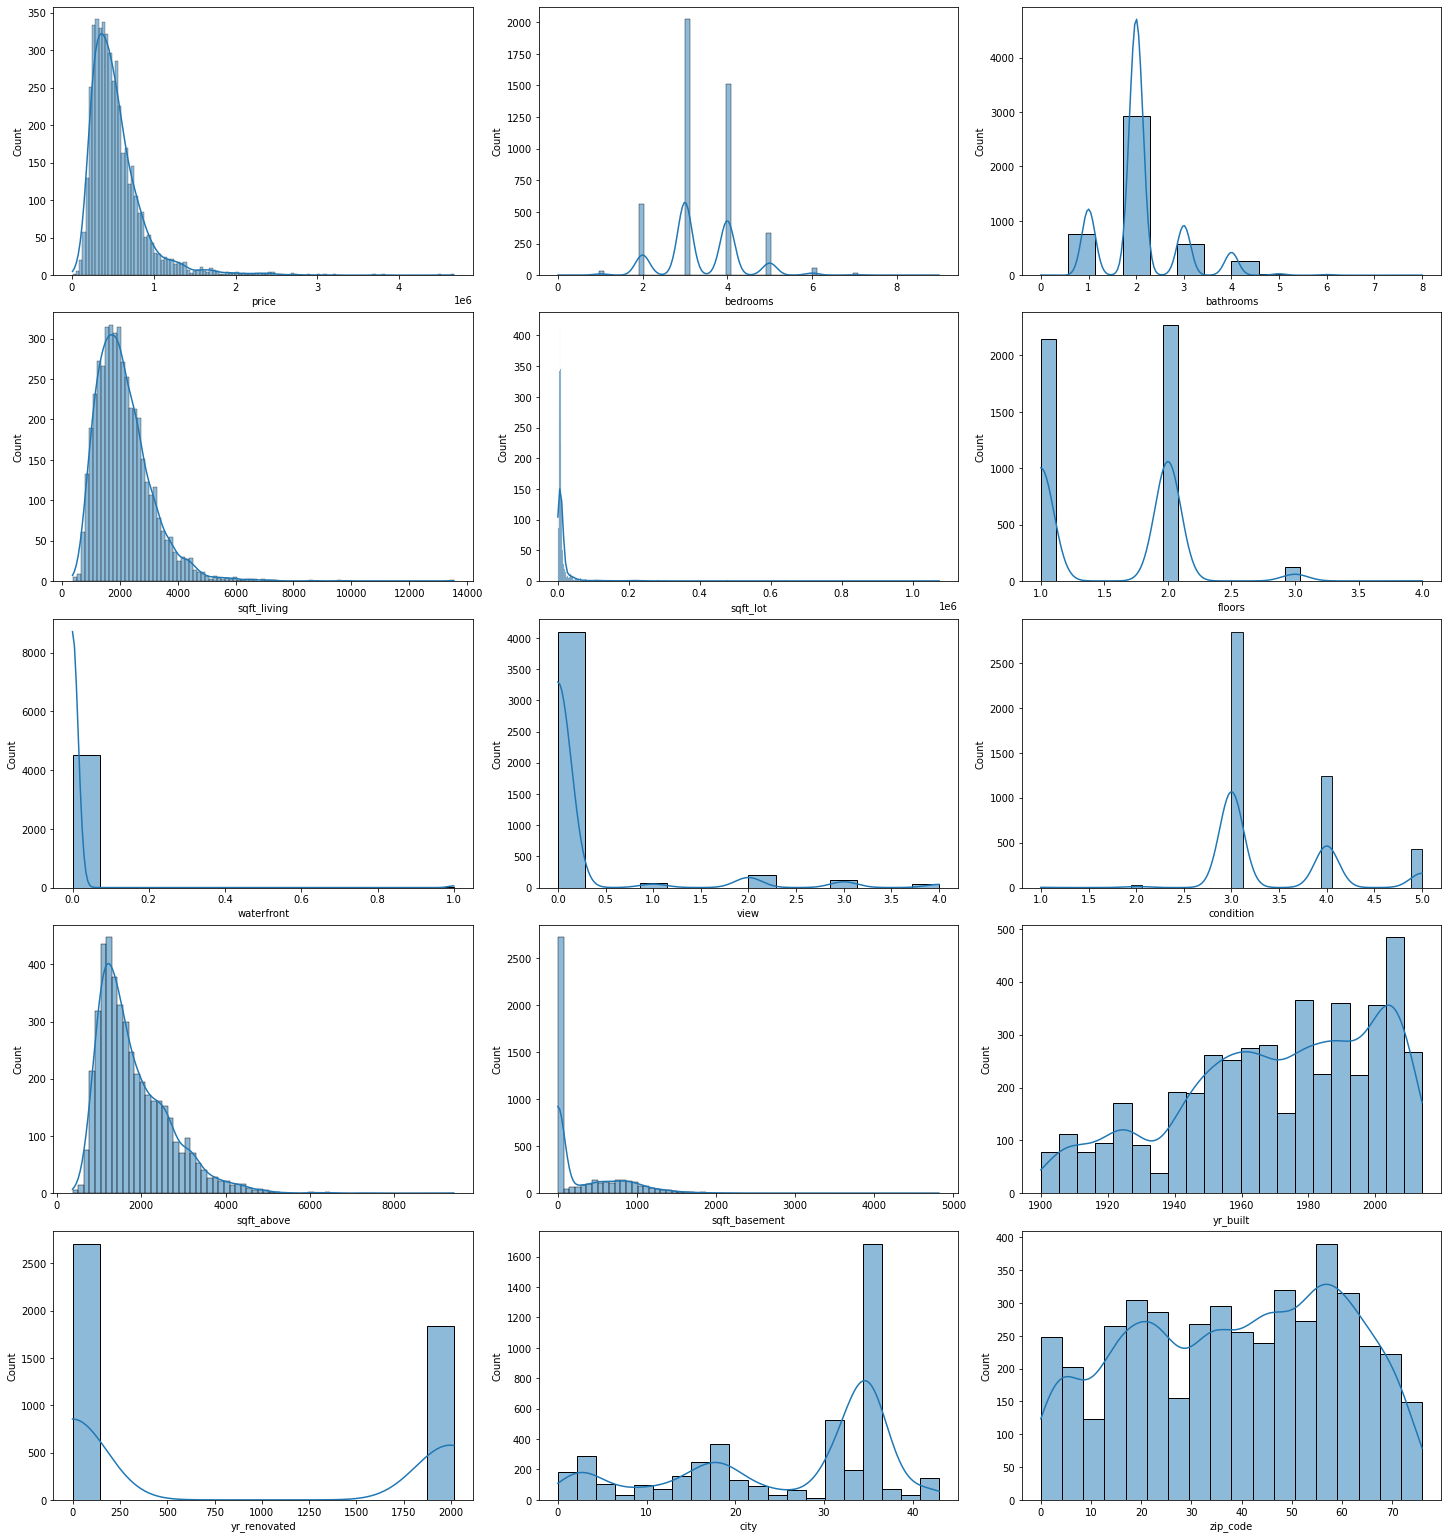

In [26]:
# Graph each variable's distribution
fig = plt.figure(figsize=(20, 25), constrained_layout=True)
for i in range(len(data.columns)):
    plt.subplot(6, 3, i+1)
    sns.histplot(data=data, x=data[data.columns[i]], kde=True)

With this figure, we can get an approximate estimation to the mean of each feature & therefore know which majority is in which interval.

But what we need to know is the correlation of each feature with the price.

Since the target feature is price, we will correlate all other features to it.

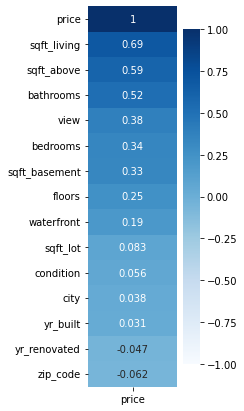

In [27]:
# Correlating features with target
plt.figure(figsize=(2, 7))
heatmap = sns.heatmap(data.corr()[['price']]
                      .sort_values(by='price', ascending=False),
                      vmin=-1, vmax=1, annot=True, cmap='Blues')

As we can see, price has its strongest correlations with sqft_living,sqft_above and bathrooms

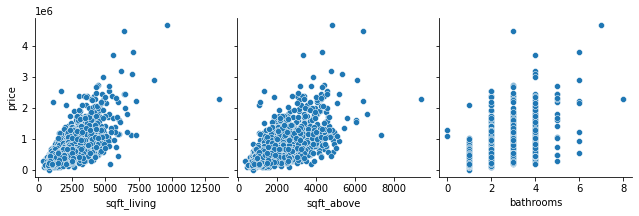

In [28]:
# Pairplot variable target with strong correlation variables target -with
sns.pairplot(data, x_vars=['sqft_living', 'sqft_above', 'bathrooms'],
             y_vars=['price'], height=3, aspect=1)



Based on the pairplot above, we can see that :

the higher each variable is, the higher the price is.
We can see 2 points that are too far away from the clusters, we can assume those are clusters or VERY particular data.

In [29]:
# Describe the small amount variable
sav = data[(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition'])]

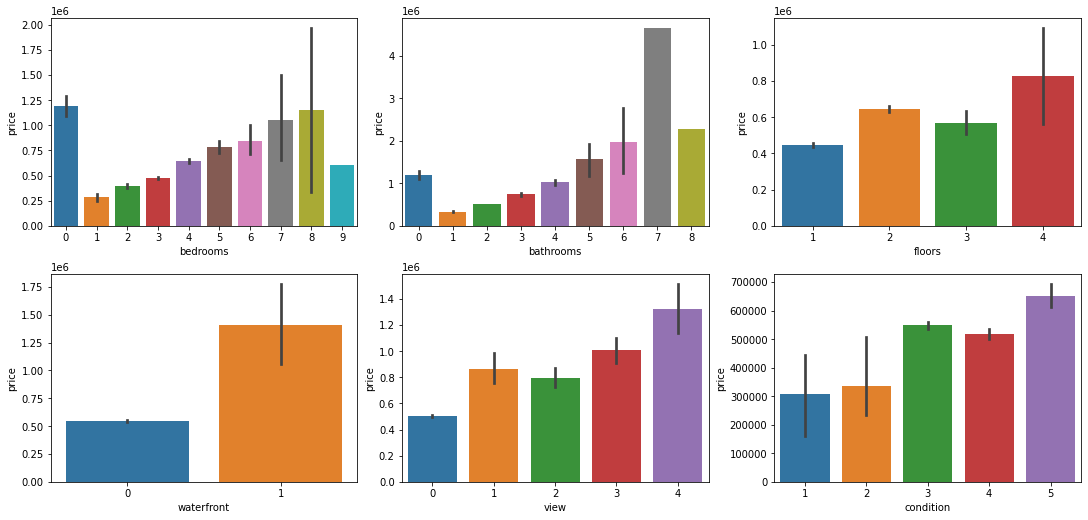

In [30]:

fig = plt.figure(figsize=(15,10), constrained_layout=True)
for i in range(len(sav.columns)):
    plt.subplot(3, 3, i+1)
    sns.barplot(data=sav, x=sav[sav.columns[i]], y=data['price'])

What we can take away from this are 2 things: 
The 0 bedroom places's value must be the occurance of a lot of outliers since no way a 0 bedroom home is higher priced than a 7-8 one.
Bathroom value seems accurate except for 2 things, the 0 bathroom value is too hight as well as the 7 one, we will be checking for outliers for that one too.
The rest seems fine.

In [31]:
bedroom_null=data.index[data['bedrooms'] == 0].tolist()
bedroom_null

[2365, 3209]

In [32]:
count = (data['bedrooms'] == 0).sum()
print('Count of zeros in Column price : ', count)

Count of zeros in Column price :  2


In [33]:
data=data.drop(bedroom_null,axis=0)
count = (data['bedrooms'] == 0).sum()
print('Count of zeros in Column price : ', count)

Count of zeros in Column price :  0


In [34]:
data.isnull().any()

price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
city             False
zip_code         False
dtype: bool

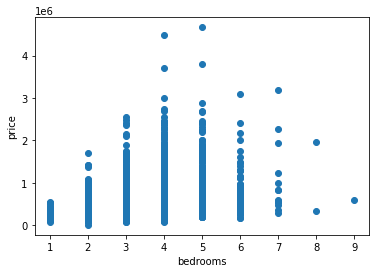

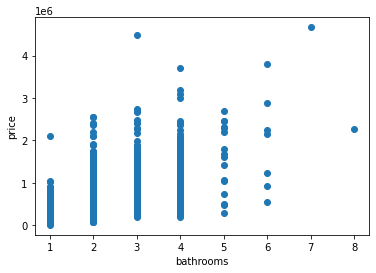

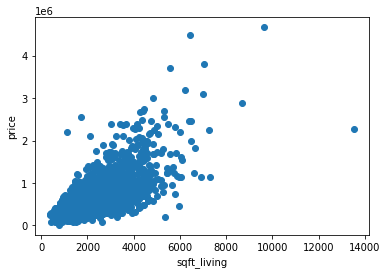

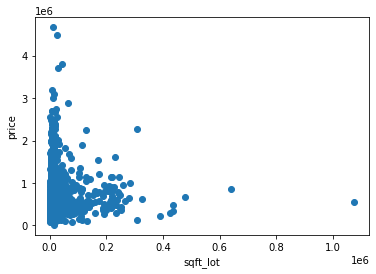

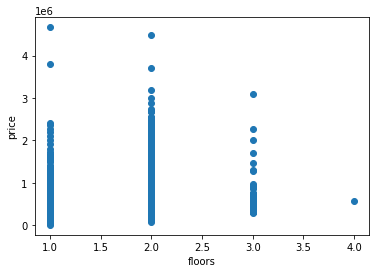

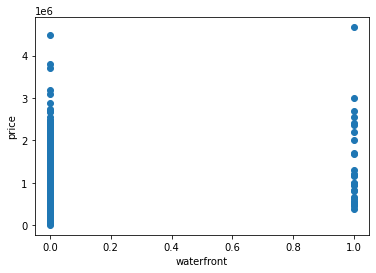

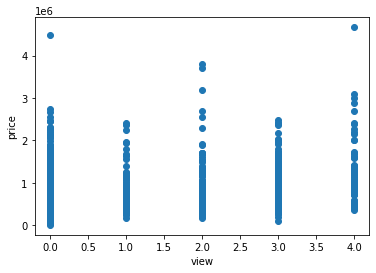

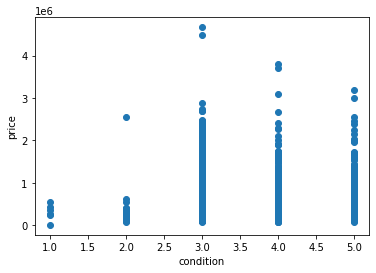

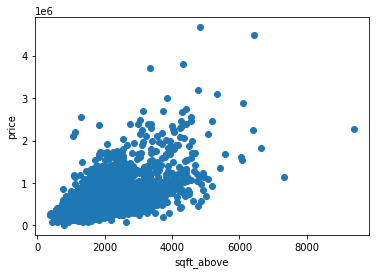

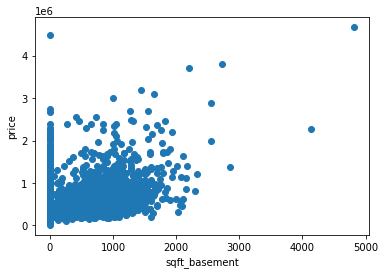

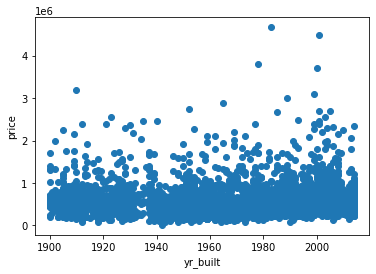

In [35]:
# Visualization -73
labels = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built']
y = 'price'
for i in range(len(labels)):
    plt.figure()
    plt.scatter(data[labels[i]], data[y])
    plt.xlabel(labels[i])
    plt.ylabel(y)

<AxesSubplot:>

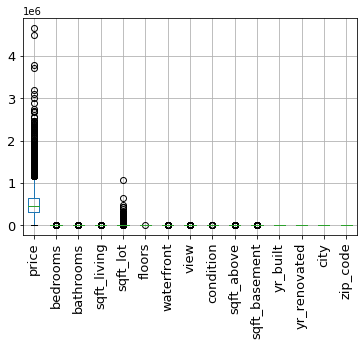

In [36]:
data.boxplot(grid=True, rot=90, fontsize=13)


No major outliers detected, everything seems to be in order

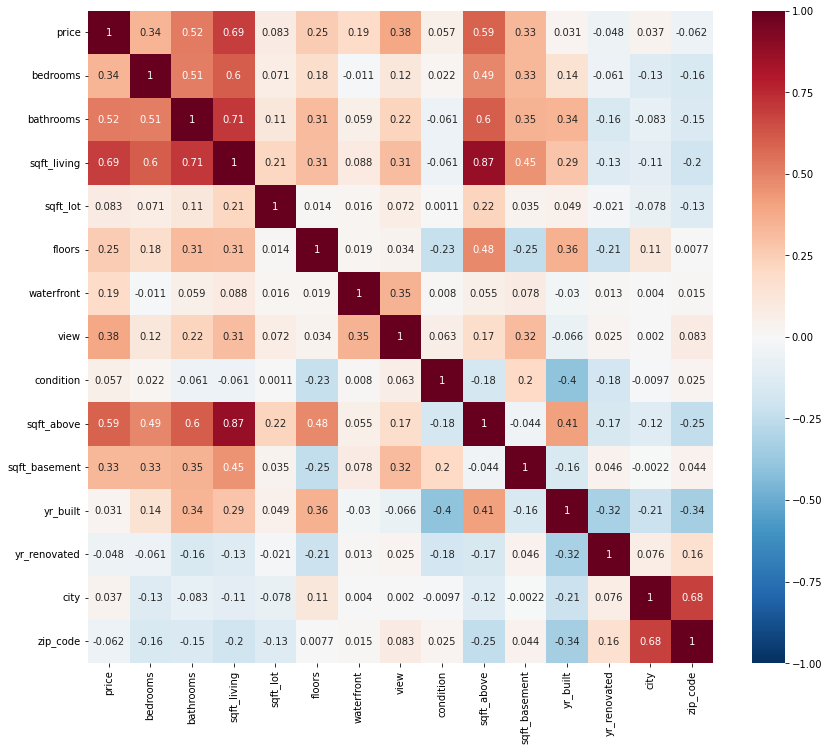

In [37]:
correlation = data.corr()
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

In [38]:
data=data.reset_index()

In [39]:
df=pd.DataFrame(data)

  <font size="+2">**Model Fitting & Evaluation**</font>

In [40]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [41]:
X = df.drop(['price'], axis=1)
y = df[['price']]

model = LinearRegression()

scores = cross_val_score(model, X, y, cv=10)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Cross-validation scores: [0.59048837 0.6246714  0.58062418 0.57625713 0.55601471 0.6851264
 0.58496441 0.57744983 0.59931512 0.27078059]
Average cross-validation score: 0.56


In [42]:
# Data Splitting

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.3, random_state=100)

In [43]:
model.fit(X_train,y_train)

LinearRegression()

In [44]:
# Describe y_predicted
y_predicted=model.predict(X_test)
y_predicted

array([[ 715770.36222548],
       [ 294149.8296734 ],
       [ 171129.75740475],
       ...,
       [1453745.52535522],
       [ 561726.41849613],
       [ 193091.91671031]])

In [45]:
model.score(X_test,y_test)

0.5867346978911862

In [46]:
# Train sxgboost
xgb = xgboost.XGBRegressor(n_estimators=400, learning_rate=0.06, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [47]:
traindf, testdf = train_test_split(X_train, test_size = 0.4)
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.06, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=400, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [48]:
predictions = xgb.predict(X_test)
print(explained_variance_score(predictions,y_test))

0.6550181979317643


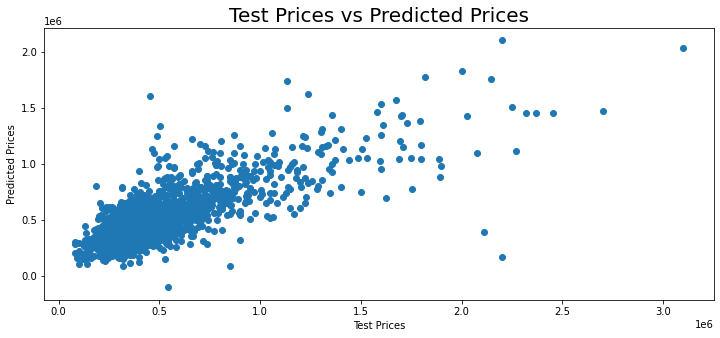

In [49]:
plt.figure(figsize=(12,5))
plt.scatter(x=y_test, y=y_predicted)
plt.xlabel("Test Prices")
plt.ylabel("Predicted Prices")
plt.title("Test Prices vs Predicted Prices", size=20)
plt.show()